In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf

# Step 1: Load the data
tesla_data = pd.read_csv('Clean_data/Cleaned_Tesla_Close.csv', parse_dates=['Date'], index_col='Date')
sp500_data = pd.read_csv('Clean_data/Cleaned_SP500_Close.csv', parse_dates=['Date'], index_col='Date')
ixic_data = pd.read_csv('Clean_data/Cleaned_IXIC_Close.csv', parse_dates=['Date'], index_col='Date')

# Merge datasets on 'Date'
merged_data = tesla_data.merge(sp500_data, left_index=True, right_index=True, suffixes=('', '_sp500'))
merged_data = merged_data.merge(ixic_data, left_index=True, right_index=True, suffixes=('', '_ixic'))

# Step 2: Preprocess the data
data = merged_data[['Close', 'Close_sp500', 'Close_ixic']]

# Scale the data after making it stationary
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.dropna())

# Prepare the dataset for LSTM
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i - time_step:i])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
# Function to reset random seeds
def reset_random_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

reset_random_seeds(seed=42)
# Step 3: Build and train the LSTM model
model = Sequential([
    LSTM(71, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.21),
    LSTM(71),
    Dropout(0.21),
    Dense(1)
])
optimizer = Adam(learning_rate=0.0018)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(X_train, y_train, epochs=163, batch_size=16, verbose=1)

# Step 4: Make predictions on the test set
test_predictions = model.predict(X_test)

test_predictions_rescaled = scaler.inverse_transform(
    np.hstack([test_predictions, X_test[:, -1, 1:]])
)[:, 0]
y_test_rescaled = scaler.inverse_transform(
    np.hstack([y_test.reshape(-1, 1), X_test[:, -1, 1:]])
)[:, 0]

# Step 5: Calculate performance metrics
test_rmse = np.sqrt(mean_squared_error(y_test_rescaled, test_predictions_rescaled))
test_mape = mean_absolute_percentage_error(y_test_rescaled, test_predictions_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, test_predictions_rescaled)

print(f'Test RMSE: {test_rmse:.2f}')
print(f'Test MAPE: {test_mape:.2%}')
print(f'Test MAE: {test_mae:.2f}')




Epoch 1/163


D:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0241
Epoch 2/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0034
Epoch 3/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0037
Epoch 4/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0030
Epoch 5/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0026
Epoch 6/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0030
Epoch 7/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0029
Epoch 8/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0028
Epoch 9/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0025
Epoch 10/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0024
Epoch 11/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0022
Epoch 12/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0021
Epoch 13/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0020
Epoch 14/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018
Epoch 15/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0020
E

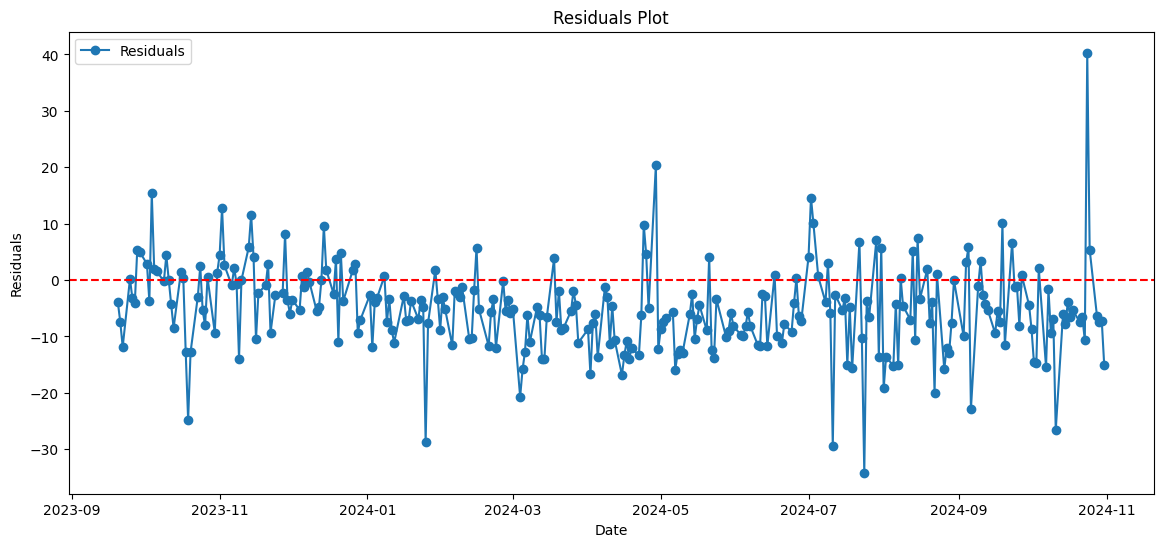

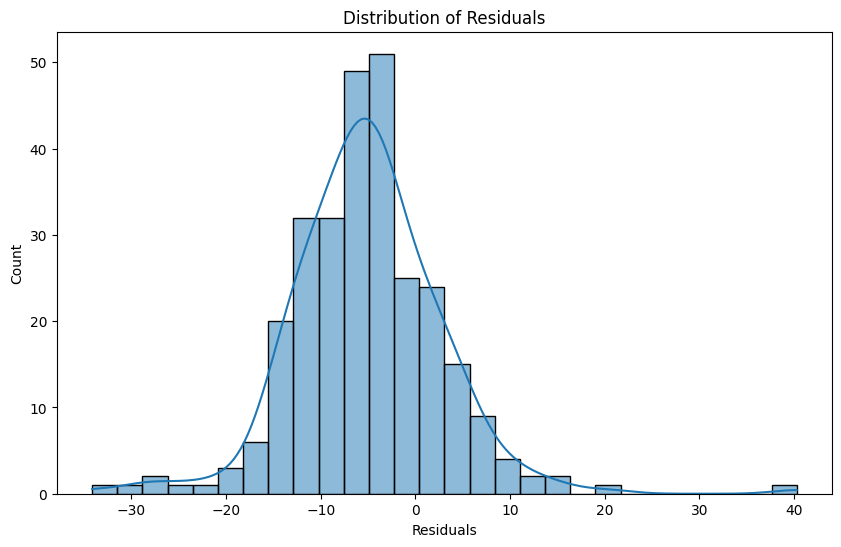

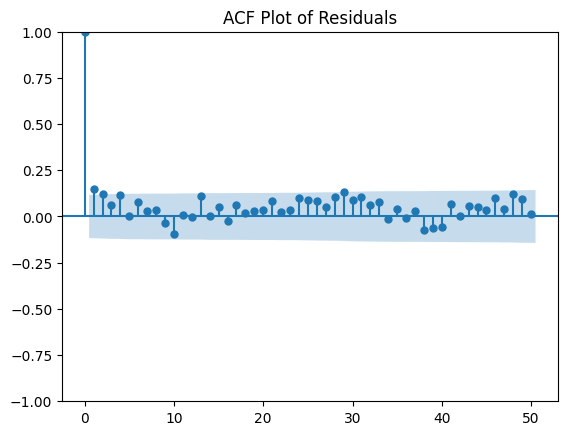

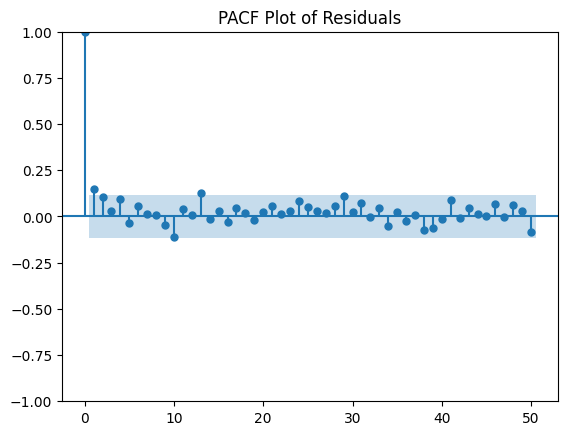

Dickey-Fuller Test:
Statistic: -14.293666912854206
p-value: 1.2630760798585565e-26

Jarque-Bera Test:
Statistic: 246.30830760566377
p-value: 3.272130228538652e-54


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera

# Điều chỉnh lại phần trục thời gian và dữ liệu
x_test_dates = merged_data.index[train_size + time_step:train_size + time_step + len(y_test_rescaled)]

# Tính dư thừa trên tập kiểm tra
residuals = y_test_rescaled - test_predictions_rescaled

# Biểu đồ dư thừa
plt.figure(figsize=(14, 6))
plt.plot(x_test_dates, residuals, marker='o', linestyle='-', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Histogram của dư thừa
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.show()

# Biểu đồ ACF cho dư thừa
plot_acf(residuals, lags=50)
plt.title('ACF Plot of Residuals')
plt.show()

# Biểu đồ PACF cho dư thừa
plot_pacf(residuals, lags=50)
plt.title('PACF Plot of Residuals')
plt.show()

# Kiểm tra tính dừng với Dickey-Fuller test
adf_test = adfuller(residuals)
print('Dickey-Fuller Test:')
print(f'Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# Kiểm tra phân phối chuẩn với Jarque-Bera test
jb_test = jarque_bera(residuals)
print('\nJarque-Bera Test:')
print(f'Statistic: {jb_test[0]}')
print(f'p-value: {jb_test[1]}')


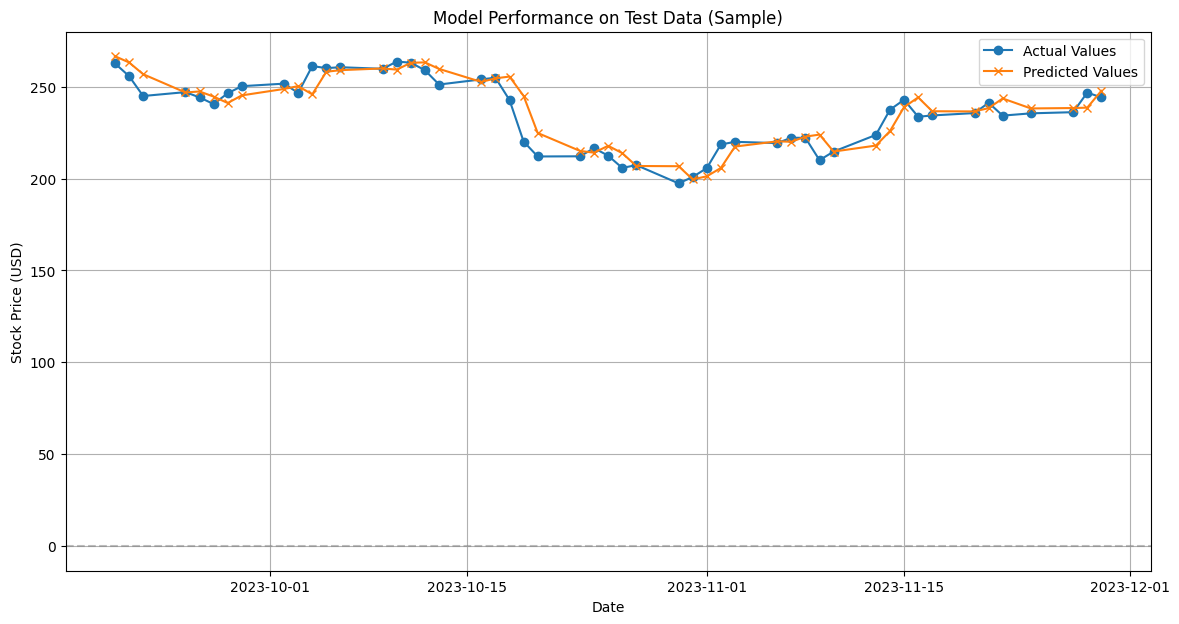

Sample RMSE: 7.33
Sample MAPE: 2.31%
Sample MAE: 5.35


In [8]:
import matplotlib.pyplot as plt

# Chọn một đoạn dữ liệu có sẵn từ tập kiểm tra (ví dụ: 50 điểm đầu tiên của test set)
sample_size = 50
sample_dates = x_test_dates[:sample_size]
y_test_sample = y_test_rescaled[:sample_size]
predictions_sample = test_predictions_rescaled[:sample_size]

# Vẽ biểu đồ so sánh giữa giá trị thật và dự đoán
plt.figure(figsize=(14, 7))
plt.plot(sample_dates, y_test_sample, label='Actual Values', marker='o')
plt.plot(sample_dates, predictions_sample, label='Predicted Values', marker='x')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.title('Model Performance on Test Data (Sample)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid()
plt.show()

# Tính sai số trên đoạn này
sample_rmse = np.sqrt(mean_squared_error(y_test_sample, predictions_sample))
sample_mape = mean_absolute_percentage_error(y_test_sample, predictions_sample)
sample_mae = mean_absolute_error(y_test_sample, predictions_sample)

print(f"Sample RMSE: {sample_rmse:.2f}")
print(f"Sample MAPE: {sample_mape:.2%}")
print(f"Sample MAE: {sample_mae:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

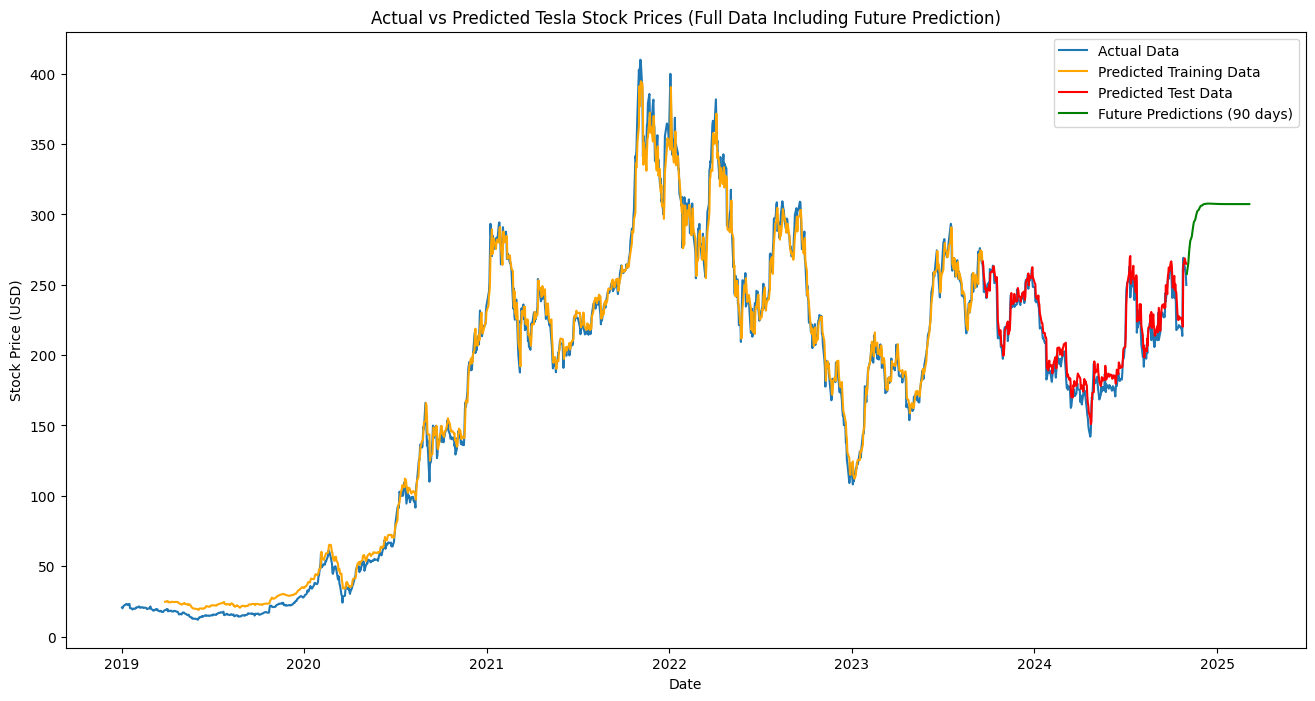

In [6]:

# Step 6: Predict future data (next 90 days)
last_60_days = scaled_data[-time_step:]
input_seq = last_60_days.reshape(1, last_60_days.shape[0], last_60_days.shape[1])

future_predictions = []
for _ in range(90):
    pred = model.predict(input_seq)
    future_predictions.append(pred[0, 0])
    next_step = np.zeros_like(input_seq)
    next_step[:, :-1, :] = input_seq[:, 1:, :]
    next_step[:, -1, 0] = pred
    next_step[:, -1, 1:] = input_seq[:, -1, 1:]
    input_seq = next_step

future_predictions_rescaled = scaler.inverse_transform(
    np.hstack([np.array(future_predictions).reshape(-1, 1), np.zeros((90, 2))])
)[:, 0]

# Step 7: Plot predictions
plt.figure(figsize=(16, 8))
plt.plot(merged_data.index, merged_data['Close'], label='Actual Data')
train_predictions = model.predict(X_train)
train_predictions_rescaled = scaler.inverse_transform(
    np.hstack([train_predictions, X_train[:, -1, 1:]])
)[:, 0]
plt.plot(merged_data.index[time_step:train_size + time_step], train_predictions_rescaled, label='Predicted Training Data', color='orange')

# Điều chỉnh lại phần trục thời gian và dữ liệu
x_test_dates = merged_data.index[train_size + time_step:train_size + time_step + len(test_predictions_rescaled)]

# Vẽ biểu đồ với trục x và y khớp nhau
plt.plot(x_test_dates, test_predictions_rescaled, label='Predicted Test Data', color='red')
future_dates = pd.date_range(start=merged_data.index[-1], periods=91, freq='B')[1:]
plt.plot(future_dates, future_predictions_rescaled, label='Future Predictions (90 days)', color='green')
plt.title('Actual vs Predicted Tesla Stock Prices (Full Data Including Future Prediction)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()